<a href="https://colab.research.google.com/github/sumanyumuku98/Generative-Adversarial-Networks-Keras/blob/master/GANS_Ian_Goodfellow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from keras.datasets import mnist,cifar10
%matplotlib inline
from keras.layers import Dense,Dropout,Input
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential,Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
plt.rcParams['image.cmap']='gray'
import warnings
warnings.filterwarnings('ignore')
import keras.backend as K
import tensorflow as tf
from keras.layers import Reshape, Flatten
from sklearn.utils import shuffle
from collections import defaultdict
import cv2



In [0]:
#Changing the directory for saving the weights
os.getcwd()
os.chdir('/Users/sumanyu/Desktop/RL/weights/')



In [0]:
#Loading the data and limiting the range of data in [0,1]
(x_train,labels_train),(x_test,labels_test) = mnist.load_data()
x_train = x_train.astype(np.float32)
x_train = x_train/255.0

In [0]:
batch_size = 512
#Defining a function for loading data in batches.
def image_loader(x_train,labels_train,batch_size):
    length = x_train.shape[0]
    start = 0
    end = batch_size
    while start < length:
        limit = min(end,length)
        yield(x_train[start:end],labels_train[start:end])
        start+=batch_size
        end+=batch_size

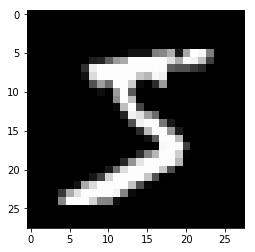

In [8]:
data_iter = image_loader(x_train,labels_train,batch_size) 
#Visualizing the data
images,labels = next(data_iter)
plt.imshow(images[0])

In [0]:
class GAN():
    def __init__(self,latent_size,image_dim,hidden_dim,X_train,labels_train,epochs=200):
        self.latent_size = latent_size
        self.image_dim = image_dim
        self.hidden_dim = hidden_dim
        self.X_train = X_train
        self.labels_train = labels_train
        self.epochs = epochs
        
    def build_generator(self):
        model = Sequential()
        model.add(Dense(self.hidden_dim,input_shape = (self.latent_size,)))    # a linear layer from latent_size to hidden dim
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.3))
        model.add(Dense(self.hidden_dim*2, activation= LeakyReLU(0.2)))
        model.add(Dropout(0.3))
        model.add(Dense(self.hidden_dim*4, activation= LeakyReLU(0.2)))
        model.add(BatchNormalization())
        model.add(Dense(self.image_dim,activation = 'tanh'))
        
        latent_vector = Input(shape = (self.latent_size,))
        gen_image = model(latent_vector)
        return Model(latent_vector,gen_image)
    
    def build_discriminator(self):
        model = Sequential()
        model.add(Dense(self.hidden_dim*4,input_shape = (self.image_dim,)))     # a linear layer from image_dim*image_dim to hidden_dim
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.3))
        model.add(Dense(self.hidden_dim*2,activation= LeakyReLU(0.2)))
        model.add(Dropout(0.3))
        model.add(Dense(self.hidden_dim,activation=LeakyReLU(0.2)))
        model.add(Dropout(0.3))
        model.add(Dense(1,activation='sigmoid'))  # sigmoid activation for probabilitu of image being fake or real
        
        image = Input(shape=(self.image_dim,))
        prob = model(image)
        
        return Model(image,prob)
        
    def train(self):
        self.batch_size = 512
        
        self.sample_size = 16
        
        self.fixed_z = np.random.uniform(-1,1,(self.sample_size,self.latent_size)) # Generating fixed random noise which will be used to test 
                                                                                   # the performance of generator
        samples = []
        discriminator = self.build_discriminator()
        generator = self.build_generator()
        noise = Input(shape=(self.latent_size,))
        fake_img = generator(noise)
        discriminator.compile(optimizer=Adam(lr=1e-3),loss = keras.losses.binary_crossentropy,metrics = ['acc'])
        # Discriminator will be trained using binary cross entropy loss as it will categorize images as fake(label=0) or real(label=1)
        discriminator.summary()
        discriminator.trainable = False
        fake = discriminator(fake_img)
        combined = Model(noise,fake)
        combined.compile(optimizer = Adam(lr = 1e-4),loss = keras.losses.binary_crossentropy,metrics=['acc'])
        # Generator will be trained as a whole with discriminator but at that time the weights of discriminator will be frozen
        combined.summary()
        
        train_history = defaultdict(list) # for storing generator and discriminator loss
        
        
        for epochs in range(self.epochs):
            epoch_gen_loss = []
            epoch_dis_loss = []
            num_batches = int(np.ceil(self.X_train.shape[0] / float(self.batch_size)))
            progbar = Progbar(target=num_batches)
            
            for batch_i, (real_images,_) in enumerate(image_loader(self.X_train,self.labels_train,self.batch_size)):
                
                batch_size = real_images.shape[0]
                real_images = real_images*2 -1
                real_images = np.reshape(real_images,(-1,real_images.shape[1]**2))
                
                real_labels = np.ones(shape=(batch_size,),dtype=int)
                random_noise = np.random.uniform(-1,1,size=(batch_size,self.latent_size))
                # Generating fake images and assigning them label 0
                fake_images = generator.predict(random_noise)
                fake_labels = np.zeros(shape=(batch_size,),dtype=np.int)
                
                final_images = np.concatenate((real_images,fake_images),axis=0)
                final_labels = np.concatenate((real_labels,fake_labels),axis = 0)

                # Shuffling the real and fake images
                final_images,final_labels = shuffle(final_images,final_labels)
                epoch_dis_loss.append(discriminator.train_on_batch(final_images,final_labels))
                
                # Generating new noise for generator and size of the batch will be twice as discriminator was trained with both real and fake images
                new_noise = np.random.uniform(-1,1,size=(2*batch_size,self.latent_size))
                new_fake_labels = np.ones(shape=(2*batch_size,), dtype=int)
                epoch_gen_loss.append(combined.train_on_batch(new_noise,new_fake_labels))
                progbar.update(batch_i+1)
                
            
            discriminator_train_loss = np.mean(np.array(epoch_dis_loss), axis=0)
            generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)
            train_history['generator'].append(generator_train_loss)
            train_history['discriminator'].append(discriminator_train_loss)
            print('At Epoch:{}-->Generator_loss:{} and Discriminator_loss:{}'.format(epochs+1,generator_train_loss[0],discriminator_train_loss[0]))

            print("Testing for epoch:{}".format(epochs+1))
            
            test_sample = generator.predict(self.fixed_z,steps = 1)
            samples.append(test_sample)
            print('Samples generated')
            
                
            if (epochs+1)%10==0:
                generator.save_weights("generator_weights_epoch:{}.h5".format(epochs+1))
                discriminator.save_weights("discriminator_weights_epoch:{}.h5".format(epochs+1))
           
        return (samples,train_history)
                

In [0]:
gan_obj = GAN(100,784,32,x_train,labels_train)
gan_obj_test = GAN(100,784,32,x_train,labels_train)


<class 'tensorflow.python.framework.ops.Tensor'> <dtype: 'float32'> (1, 784)
(1, 28, 28)


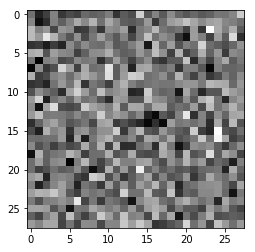

In [11]:
#Testing the generator
generator = gan_obj.build_generator()
z = np.random.uniform(low = -1.0,high = 1.0,size = (1,100))
z_ten = K.variable(z)
output_image = generator(z_ten)
print(type(output_image),output_image.dtype,output_image.shape)
sess = tf.Session()
reshaped_image = Reshape((28,28))(output_image)
print(reshaped_image.shape)
K.set_session(sess)
plt.imshow(K.eval(reshaped_image)[0])


In [12]:
history = gan_obj_test.train()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 110849    
Total params: 110,849
Trainable params: 110,849
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_3 (Model)              (None, 784)               115312    
_________________________________________________________________
model_2 (Model)              (None, 1)                 110849    
Total params: 226,161
Trainable params: 115,056
Non-trainable params: 

In [13]:
samples = history[0]
len(samples)

200

In [0]:
def view_samples(epoch, samples,img_dim=28):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch-1]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((img_dim,img_dim)), cmap='Greys_r')


Test Samples for epoach:0-->
Test Samples for epoach:50-->
Test Samples for epoach:100-->
Test Samples for epoach:150-->


<Figure size 432x288 with 0 Axes>

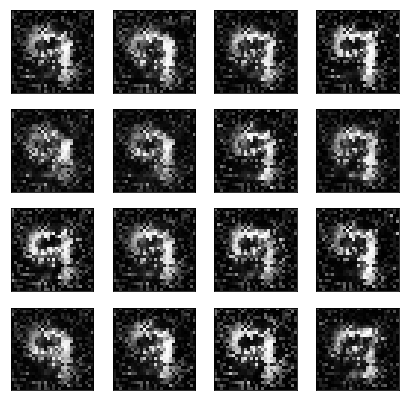

<Figure size 432x288 with 0 Axes>

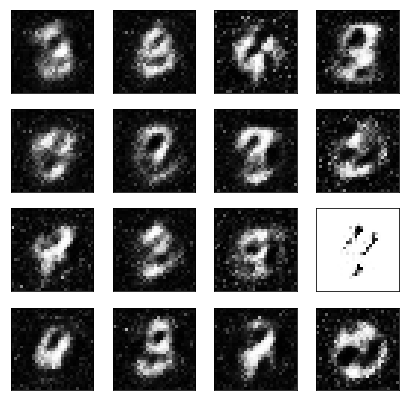

<Figure size 432x288 with 0 Axes>

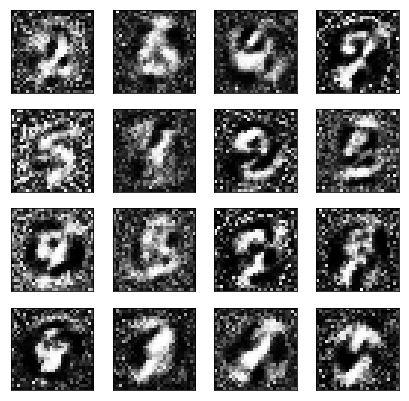

<Figure size 432x288 with 0 Axes>

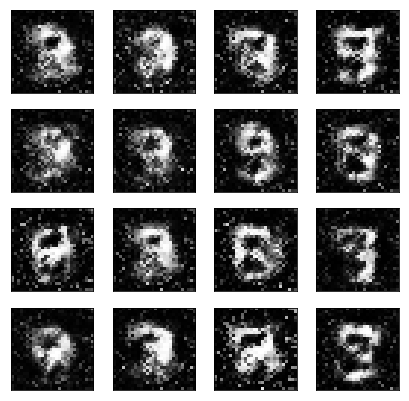

In [22]:
for epoch in range(0,len(samples),50):
  print('Test Samples for epoach:{}-->'.format(epoch))
  view_samples(epoch,samples)

In [0]:
(cifar_x_train,cifar_labels_train), (cifar_x_test,cifar_labels_test) = cifar10.load_data()


In [45]:
cifar_x_train.shape

(50000, 32, 32, 3)

In [0]:
# conversion for rgb image to grayscale
def rgb2gray(images):
  return np.dot(images[...,:3], [0.299, 0.587, 0.114])
  

(32, 32, 3)
(32, 32)


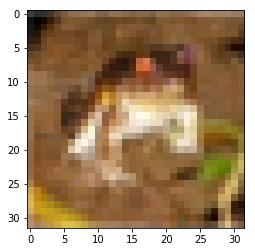

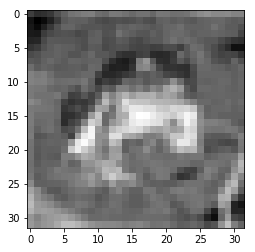

In [49]:
cifar_example = cifar_x_train[0]
print(cifar_example.shape)
plt.figure(0)
plt.imshow(cifar_example)
cifar_example_gray = rgb2gray(cifar_example)
print(cifar_example_gray.shape)
# Visualisation
plt.figure(1)
plt.imshow(cifar_example_gray)


In [53]:
cifar_x_train_gray = rgb2gray(cifar_x_train)
print(cifar_x_train_gray.shape)
cifar_x_train_gray =cifar_x_train_gray/255.0

(50000, 32, 32)


In [0]:
cifar_gan_obj = GAN(100,32*32,32,cifar_x_train_gray,cifar_labels_train,epochs=120)

In [55]:
history = cifar_gan_obj.train()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 141569    
Total params: 141,569
Trainable params: 141,569
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 100)               0         
_________________________________________________________________
model_9 (Model)              (None, 1024)              146272    
_________________________________________________________________
model_8 (Model)              (None, 1)                 141569    
Total params: 287,841
Trainable params: 146,016
Non-trainable params: 

In [0]:
cifar_test_samples = history[0]
loss_values = history[1]

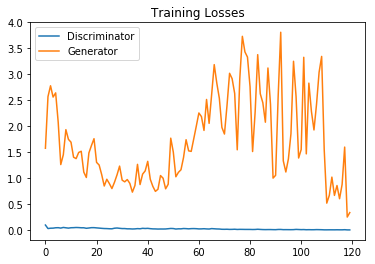

In [66]:
gen_loss,gen_acc = zip(*loss_values['generator'])
dis_loss,dis_acc = zip(*loss_values['discriminator'])
fig, ax = plt.subplots()
plt.plot(dis_loss, label='Discriminator')
plt.plot(gen_loss, label='Generator')
plt.title("Training Losses")
plt.legend()

Test Samples for epoch:0-->
Test Samples for epoch:40-->
Test Samples for epoch:80-->
Test Samples for epoch:120-->


<Figure size 432x288 with 0 Axes>

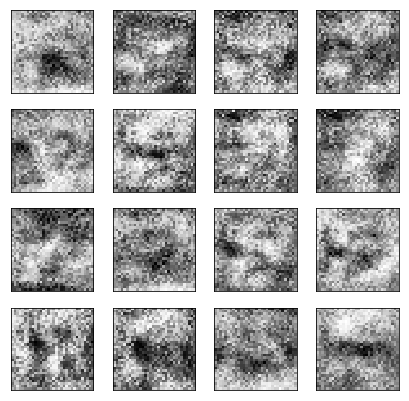

<Figure size 432x288 with 0 Axes>

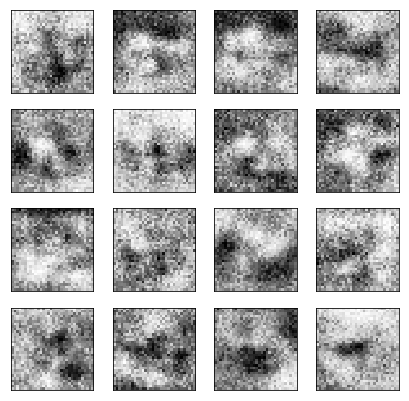

<Figure size 432x288 with 0 Axes>

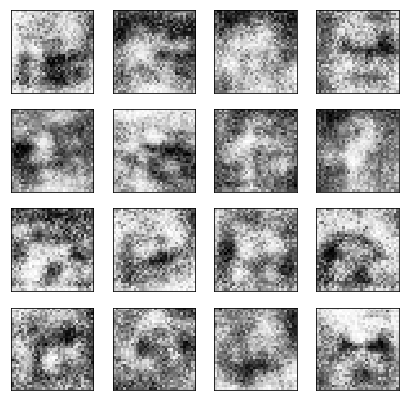

<Figure size 432x288 with 0 Axes>

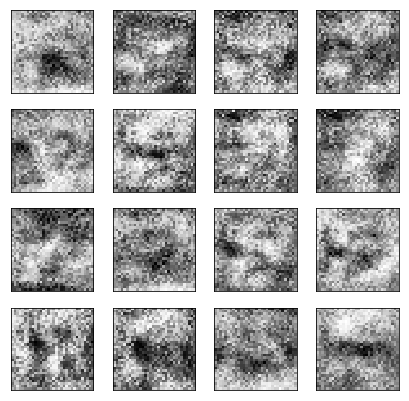

In [73]:
for epoch in range(0,len(cifar_test_samples)+1,40):
  print('Test Samples for epoch:{}-->'.format(epoch))
  plt.figure(epoch)
  view_samples(epoch,cifar_test_samples,32)
  